In [1]:
# # 这是我电脑自己环境的问题，你们不用运行
# import sys
# sys.path
# sys.path.remove('C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python38\\site-packages')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
from math import *
import random
from scipy.optimize import minimize

colors = ["grey", "brown", "orange", "olive", "green", "cyan",
              "blue", "purple", "pink", "red"]

# colors = ['black', 'gray', 'firebrick', 'red', 'chocolate',
#               'orange', 'peru', 'darkgoldenrod', 'olive',
#               'yellow', 'green', 'turquoise', 'deepskyblue',
#               'blue', 'violet', 'purple', 'deeppink']

# 0. LDA

In [3]:
# 返回质心向量
def getTwoClassMean(c0, c1):
    """
    get the mean vector of two class
    """
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    return mean0_vectors, mean1_vectors
# 返回SW SB
def getClassScatterMatrix(c0, c1):
    """
    input two class data
    return the scatter for each class
    and with-in sc_mat and between sc_mat
    """
    mean0_vectors, mean1_vectors = getTwoClassMean(c0, c1)
    num0 = c0.shape[0]
    num1 = c1.shape[0]
    dim = c0.shape[1]
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape((dim, 1))
    for row in c0:
        row = row.reshape((dim, 1))
        class0_sc_mat += (row-mv).dot((row-mv).T)
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    for row in c1:
        row = row.reshape((dim, 1))
        class1_sc_mat += (row-mv).dot((row-mv).T)
    S_W = class0_sc_mat + class1_sc_mat
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)
    overall_mean = overall_mean.reshape((dim, 1))
    mean_vec = mean0_vectors.reshape((dim, 1))
    S_B = np.zeros((dim, dim))
    S_B += num0 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    mean_vec = mean1_vectors.reshape((dim, 1))
    S_B += num1 * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return class0_sc_mat, class1_sc_mat, S_W, S_B


# 返回LDA目标函数在该投影下的值
def getLDAValue(S_W, S_B, w):
    result_cost = 1.0 * w.T.dot(S_B).dot(w) / w.T.dot(S_W).dot(w)
    return result_cost


# 手动实现 LDA
def lda(c0, c1):
    """
    type is ndarray
    shape like (200,2) and 200 is the number of samples and 2 is the number of features
    pass two class data to the function
    return the Eigenvectors using LDA
    the solve method is Eigenvalue Decomposition
    """
    # get the basic information
    dim = c0.shape[1]  # the dim is the number of features, for instance, the dim of iris is 4
    c = np.concatenate((c0, c1))  # Vertical stacking, default axis is 0
    overall_mean = np.mean(c, axis=0)  # the overall_mean of the samples
    # print("overall_mean: ", overall_mean)
    num0 = c0.shape[0]  # the number of class-0
    num1 = c1.shape[0]  # the number of class-1

    # Computing the mean vectors
    mean0_vectors = np.mean(c0, axis=0)
    mean1_vectors = np.mean(c1, axis=0)
    S_W = np.zeros((dim, dim))
    class0_sc_mat = np.zeros((dim, dim))
    mv = mean0_vectors.reshape(dim, 1)
    # print("mv: ", mv)
    for row in c0:
        row = row.reshape(dim, 1)
        # print("row-mv: \n", row-mv)
        class0_sc_mat += (row-mv).dot((row-mv).T)
        # print("class0_sc_mat: ", class0_sc_mat)
    S_W += class0_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # for class1, al S_W1
    class1_sc_mat = np.zeros((dim, dim))
    mv = mean1_vectors.reshape((dim, 1))
    # print("mv: ", mv)
    for row in c1:
        row = row.reshape(dim, 1)
        class1_sc_mat += (row-mv).dot((row-mv).T)
        
    
    S_W += class1_sc_mat
    # print("within-class Scatter Matrix: \n", S_W)

    # Between-class scatter matrix S_B
    S_B = np.zeros((dim, dim))
    # print("overall_mean: ", overall_mean)
    overall_mean = overall_mean.reshape(dim, 1)
    mean_vec = mean0_vectors.reshape(dim, 1)
    S_B += num0*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    mean_vec = mean1_vectors.reshape(dim, 1)
    S_B += num1*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    # print("between-class Scatter Matrix: \n", S_B)

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(S_W).dot(S_B))
    # for i in range(len(eig_vals)):
    #     eigvec_sc = eig_vecs[:, i].reshape(dim, 1)
    #     print("\nEigenvector {}: \n{}".format(i+1, eigvec_sc.real))
    #     print("Eigenvalue {:}: {:.2e}".format(i+1, eig_vals[i].real))

    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]


    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)


    return [i[1] for i in eig_pairs]

# 1. GONG

In [4]:
def get_distance_to_point(P1, P2):

    dx = abs(P1[0] - P2[0])
    dy = abs(P1[1] - P2[1])
    return math.sqrt(dx * dx + dy * dy)


# 计算一个点的GONG值，即所定义的set中与自己同类别所占的比例
def cal_one_point_GONG(Points, Label, i):
    omega = 0
    same_indicator = 0
    tot_num = Points.shape[0]
    for j in range(tot_num):
        if j == i:
            continue
        flag = True
        intermediary_point = 0.35 * Points[j] + 0.65 * Points[i]
        int2j_dist = get_distance_to_point(intermediary_point, Points[j])
        for k in range(tot_num):
            if k == i:
                continue
            dist = get_distance_to_point(intermediary_point, Points[k])
            if dist < int2j_dist:
                flag = False
                break
        if flag == False:
            continue
        omega += 1
        if Label[i] == Label[j]:
            same_indicator += 1
    if omega == 0:
        return 0
    return same_indicator/omega


# 计算某个类的GONG值（该类下所有点的GONG值取平均）
def get_label_GONG(Points, Label, lab):
    GONG_list = []
    tot_num = Points.shape[0]
    for i in range(tot_num):
        GONG_list.append(cal_one_point_GONG(Points, Label, i))
    GONG_list = np.array(GONG_list)
    return np.mean(GONG_list[Label == lab])


# 计算一个投影的GONG（即每个类的GONG值的加权平均）
def get_GONG_value(data, Label, evaluation):
    if evaluation == "Silhouette Coefficient":
        return metrics.silhouette_score(Points, Label)
    answer = 0
    for lab in set(label):
        answer += get_label_GONG(data, label, lab) * len(label[label == lab]) / len(label)
    return answer
    
    
def get_weighted_GONG(data, label, proj_set, proj_set_labels):
    """
    计算整个图的加权GONG值
    输入：原始数据data，label，投影集projection_set
    data和一个投影平面projection_set[i],可以组成投影后的data_
    对于每个类：
    计算这个类在所有投影中的GONG
    取最大值，作为这个类的GONG
    最终对每个类的GONG加权，得到整个图的加权GONG
    """
    proj_num = len(proj_set)
    
    label_count = {}
    GONG = []# GONG[i][j] 代表：在投影i上，第j个类的GONG值
    for i in range(proj_num):
        proj = proj_set[i]
        proj_label = proj_set_labels[i]
        GONG_list = {}

        data_0, data_1, data_, label_ = project_on_merged_vectors(data, label, set(proj_label), proj[0], proj[1])
        
        # 计算该投影下每一个类的GONG
        for lab in set(label_): 
            GONG_list[lab] = get_label_GONG(data_,label_,lab)
            label_count[lab] = len(label[label==lab])
            
        print(GONG_list)
        # 存入GONG
        GONG.append(GONG_list)
        
    label_GONG = {}
    for GONG_list in GONG:
        for key in GONG_list:
            if key not in label_GONG:
                label_GONG[key] = GONG_list[key]
            else:
                label_GONG[key] = max(label_GONG[key], GONG_list[key])
            
    print('-------')
    print(label_GONG)
    print(label_count)
    weighted_GONG = 0 
    
    cnt = 0
    for key in label_GONG:
        weighted_GONG += label_GONG[key] * label_count[key]
        cnt += label_count[key]

    weighted_GONG /= cnt
    return weighted_GONG

# 2. Load Dataset

In [5]:
def read_data_from_file(filename):
    """
    :param filename: the data file, the format is class_label, dim0, dim1, ...
    :return: data and label
    """
    newfilename = './Data/' + filename  # because my data is in the Data folder
    data = []
    with open(newfilename, 'r') as f:
        for line in f:
            data.append(list(eval(line)))
    data = np.array(data)
    dim = data.shape[1]
    return data[:, 1:dim], data[:, 0]


# # 重新编排label为0, 1, 2,...
def get_label_right(label):
    class_label = list(set(label))
    label_dict = {}
    re_label = 0
    for it in class_label:
        label_dict[it] = re_label
        re_label += 1
    new_label = []
    for it in label:
        new_label.append(label_dict[it])
    return np.array(new_label)

In [36]:
#2个类的文件都要踢出来
import os

path = r'.\Data'
dirs = os.listdir(path)
file_names = []
for fname in dirs:
    data, label = read_data_from_file(fname)
    file_names.append(fname)
    # if(len(set(label)) == 2):
#     print(fname, len(set(label)))

# file_names

balance-scale.csv 3
bbdm13_origClassLabels.csv 5
boston_origClassLabels.csv 3
breast-cancer-wisconsin_origClassLabels.csv 2
breast_cancer.csv 2
cars03Cropped_d1_origClassLabels..csv 2
cars03Cropped_d1_origClassLabels.csv 2
cars03Cropped_d3_origClassLabels.csv 12
cereal_origClassLabels.csv 7
cmc.csv 3
combined_scale.csv 3
Connectionist_Bench_Vowel Recognition_Deterding_Data.csv 11
dermatology.csv 6
digits5_8.csv 5
ecoliproteins.csv 8
efashion_origClassLabels.csv 8
fisheries_clusteredByEscapementTarget.csv 11
fisheries_clusteredByHarvestRule.csv 11
ForestTypes.csv 4
hayes-roth.csv 3
Hill_Valley_with_noise_Testing.csv 2
hiv.csv 6
interleaved_100_200_10d_0_notcramped_notrotated.csv 10
interleaved_100_200_10d_25_cramped_rotated.csv 10
interleaved_100_200_15d_0_notcramped_notrotated.csv 15
interleaved_100_200_15d_25_cramped_rotated.csv 15
interleaved_100_200_4d_0_notcramped_notrotated.csv 4
interleaved_100_200_4d_25_cramped_rotated.csv 4
interleaved_100_200_5d_0_notcramped_notrotated.csv 5
i

In [8]:
# Change the following two lines to fit your data
fname = "bbdm13_origClassLabels.csv"  # the class data file
data, label = read_data_from_file(fname)
# data, label = X, y
label = get_label_right(label)
label = np.array(list(map(int, label)))
print(data.shape)
print(label)

(200, 13)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4]


# 3. Generate the discriminatiive

In [9]:
# 确保该向量方向是对的

def get_right_direction(vec, last_axis):
    if np.dot(vec, last_axis) < 0:
        return -vec
    return vec


def normalize(v):
        return v / np.linalg.norm(v)


# 第一步：寻找LDA下的最佳discriminative vector
def get_optimal_vector_from_lda(c0, c1):
    discriminating_vectors = lda(c0, c1)
    opt_vec = np.real(discriminating_vectors[0])  # ndarray
    return opt_vec


# ? last_axis
# 寻找每两个类之间的最佳投影向量  (c0,c1):vector
def get_between_class_opt_vec(data, label):
    """
    :param data: the input data
    :param label: The label of the data
    :return: the optimal discriminant vector corresponding to (class a, class b)
    """
    class_list = list(set(label))
    vec_dict = {}
    class_num = len(class_list)
    # dim = data.shape[1]
    # last_axis = np.array([0 for i in range(dim)])
    # last_axis[dim - 1] = last_dim
    # 对于每两个类
    for i in range(class_num):
        for j in range(i+1, class_num):
            # 计算最佳投影向量并加入字典
            opt_vec = get_optimal_vector_from_lda(data[label == class_list[i]],data[label == class_list[j]])
            opt_vec = normalize(opt_vec)
            # opt_vec = get_right_direction(opt_vec, last_axis)
            vec_dict[(class_list[i], class_list[j])] = opt_vec
    vecs = []
    for key in vec_dict:
        vecs.append(np.array(vec_dict[key]))
    vecs = np.array(vecs)
    return vec_dict, vecs

In [10]:
vec_dict, vecs = get_between_class_opt_vec(data, label)
display(vecs)      # vec_dict.values() 按指定顺序
display(vec_dict)  # key: (vid1, vid2), value: discriminative vector

array([[ 0.5806793 , -0.08461238, -0.28869257, -0.55099013, -0.04287863,
        -0.20780666, -0.33395831,  0.01665775, -0.19900042, -0.20980496,
        -0.1563942 , -0.01764585, -0.05917058],
       [ 0.13380334, -0.15679163, -0.07559819, -0.75926333, -0.04337614,
         0.02241905, -0.53410592,  0.00101934,  0.1823538 , -0.1482959 ,
        -0.17947255,  0.00734119, -0.0124103 ],
       [ 0.47314399,  0.14972783, -0.17045374,  0.11942921,  0.02410798,
        -0.06680971, -0.62187197, -0.00356493,  0.17770419, -0.51108374,
        -0.03995397,  0.01918519, -0.15448811],
       [ 0.23383467,  0.03973865, -0.10669721, -0.01714943,  0.25425708,
        -0.81558798, -0.31619167,  0.00729267,  0.19925398, -0.20364725,
        -0.12039757,  0.00857956, -0.08037096],
       [ 0.07899713, -0.16920849, -0.52831326, -0.69604269,  0.00411789,
        -0.17680385, -0.37037199, -0.01439017,  0.07756824, -0.14855901,
         0.06305438,  0.00132432,  0.02853669],
       [ 0.53950781, -0.034644

{(0,
  1): array([ 0.5806793 , -0.08461238, -0.28869257, -0.55099013, -0.04287863,
        -0.20780666, -0.33395831,  0.01665775, -0.19900042, -0.20980496,
        -0.1563942 , -0.01764585, -0.05917058]),
 (0,
  2): array([ 0.13380334, -0.15679163, -0.07559819, -0.75926333, -0.04337614,
         0.02241905, -0.53410592,  0.00101934,  0.1823538 , -0.1482959 ,
        -0.17947255,  0.00734119, -0.0124103 ]),
 (0,
  3): array([ 0.47314399,  0.14972783, -0.17045374,  0.11942921,  0.02410798,
        -0.06680971, -0.62187197, -0.00356493,  0.17770419, -0.51108374,
        -0.03995397,  0.01918519, -0.15448811]),
 (0,
  4): array([ 0.23383467,  0.03973865, -0.10669721, -0.01714943,  0.25425708,
        -0.81558798, -0.31619167,  0.00729267,  0.19925398, -0.20364725,
        -0.12039757,  0.00857956, -0.08037096]),
 (1,
  2): array([ 0.07899713, -0.16920849, -0.52831326, -0.69604269,  0.00411789,
        -0.17680385, -0.37037199, -0.01439017,  0.07756824, -0.14855901,
         0.06305438,  0.

In [11]:
def get_id_pair(vec_dict):
    i = 0
    id_pair = {}
    id_vecs = {}
    for key in vec_dict:
        id_pair[i] = key
        id_vecs[i] = vec_dict[key]
        i += 1
    return id_pair, id_vecs

# vid -- labels -- vec 三者一一对应
# vid号判别向量区分pair对应的两个label，这个判别向量存在vec内
id_pair, id_vecs = get_id_pair(vec_dict)
print(id_vecs)
print(id_pair)

{0: array([ 0.5806793 , -0.08461238, -0.28869257, -0.55099013, -0.04287863,
       -0.20780666, -0.33395831,  0.01665775, -0.19900042, -0.20980496,
       -0.1563942 , -0.01764585, -0.05917058]), 1: array([ 0.13380334, -0.15679163, -0.07559819, -0.75926333, -0.04337614,
        0.02241905, -0.53410592,  0.00101934,  0.1823538 , -0.1482959 ,
       -0.17947255,  0.00734119, -0.0124103 ]), 2: array([ 0.47314399,  0.14972783, -0.17045374,  0.11942921,  0.02410798,
       -0.06680971, -0.62187197, -0.00356493,  0.17770419, -0.51108374,
       -0.03995397,  0.01918519, -0.15448811]), 3: array([ 0.23383467,  0.03973865, -0.10669721, -0.01714943,  0.25425708,
       -0.81558798, -0.31619167,  0.00729267,  0.19925398, -0.20364725,
       -0.12039757,  0.00857956, -0.08037096]), 4: array([ 0.07899713, -0.16920849, -0.52831326, -0.69604269,  0.00411789,
       -0.17680385, -0.37037199, -0.01439017,  0.07756824, -0.14855901,
        0.06305438,  0.00132432,  0.02853669]), 5: array([ 0.53950781, -

# 4. Get All Plains

In [12]:
def cal_angle(v1,v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))

# Problem1：平面角度的计算
def get_distance(plane1, plane2):
    n = len(plane1)
    res = 0
    for i in range(n):
        res += cal_angle(plane1[i], plane2[i])**2
    res /= n 
    return np.sqrt(res)


# 使用前提：plain 的基坐标 v1，v2 是单位向量
def get_dist_to_plain(plain, v):
    length = int(len(plain)/2)
    v1, v2 = plain[0:length], plain[length:]
    len_v1, len_v2 = np.linalg.norm(v1), np.linalg.norm(v2)
    new_v = np.dot(np.dot(v1, v), v1) / len_v1 + np.dot(np.dot(v2, v), v2) / len_v2
    return np.linalg.norm(v-new_v)
    
    
def get_fitted_plain(vecs):
    if len(vecs) == 2:
        axis1, axis2 = vecs[0], vecs[1]

        axis1 = normalize(axis1)
        a = 1
        axis1_length = 1
        b = -a / np.dot(axis2, axis1)
        axis2 = normalize(a*axis1+b*axis2)
        plain = np.array([axis1, axis2])
        print('dists-->',np.sum([get_dist_to_plain(plain, feature) for feature in vecs]))
        return np.array([axis1, axis2])

    length = len(vecs[0])

    def fun(args):
        _vecs = args
        dists = lambda P: np.sum([get_dist_to_plain(P, v) for v in _vecs])
        return dists

    def con():
        # 约束条件：两个基模长为1
        cons = (
            {'type': 'eq', 'fun': lambda P: np.linalg.norm(P[0])-1},
            {'type': 'eq', 'fun': lambda P: np.linalg.norm(P[1])-1}
        )
        return cons

    # Problem2: 条件极值？
    # ans = fmin(fun, np.array([normalize(np.random.random(length)), normalize(
    #     np.random.random(length))]), maxfun=100000)

    cons = con()
    ans = minimize(fun(vecs), x0=np.array([normalize(np.random.random(length)), normalize(
          np.random.random(length))]), method='SLSQP', options={"disp": True})

    print(ans.x)
    # print(ans.fun)
    ans_x = ans.x

    axis1, axis2 = ans_x[0:length], ans_x[length:]
    print(np.linalg.norm(axis1), np.linalg.norm(axis2))
    plain = np.array([axis1, axis2])

    axis1 = normalize(axis1)
    a = 1
    b = -a / np.dot(axis2, axis1)
    axis2 = normalize(a*axis1+b*axis2)

    plain = np.array([axis1, axis2])
    print('dists-->',
          np.sum([get_dist_to_plain(plain, v) for v in vecs]))
    return plain


def get_all_plains(vecs, id_pair):
    plains = []
    pid_vids = {}
    pid_labels = {}
    pid = 0
    for i in range(len(vecs)):
        for j in range(i + 1, len(vecs)):
            plain = get_fitted_plain([vecs[i], vecs[j]])
            print(plain)
            plains.append(plain)
            pid_labels[pid] = list(set([id_pair[i][0], id_pair[i][1], id_pair[j][0], id_pair[j][1]]))
            pid_vids[pid] = [i, j]
            pid += 1
    
    return plains, pid_labels, pid_vids

In [13]:
planes, pid_labels, pid_vids = get_all_plains(vecs, id_pair)

dists--> 4.2116050429029244e-16
[[ 0.5806793  -0.08461238 -0.28869257 -0.55099013 -0.04287863 -0.20780666
  -0.33395831  0.01665775 -0.19900042 -0.20980496 -0.1563942  -0.01764585
  -0.05917058]
 [ 0.42478759  0.13905778 -0.19790452  0.52241365  0.0176597  -0.25491864
   0.42482101  0.01631187 -0.47959879 -0.00718344  0.0955346  -0.02960504
  -0.04507708]]
dists--> 1.3601633860597272e-16
[[ 0.5806793  -0.08461238 -0.28869257 -0.55099013 -0.04287863 -0.20780666
  -0.33395831  0.01665775 -0.19900042 -0.20980496 -0.1563942  -0.01764585
  -0.05917058]
 [-0.18254117 -0.23582647  0.01301548 -0.50890217 -0.05738129 -0.05769983
   0.5247251   0.01533049 -0.34529593  0.4741436  -0.05581754 -0.03473181
   0.14614073]]
dists--> 1.6454138064445248e-16
[[ 5.80679299e-01 -8.46123820e-02 -2.88692567e-01 -5.50990126e-01
  -4.28786260e-02 -2.07806655e-01 -3.33958305e-01  1.66577490e-02
  -1.99000415e-01 -2.09804961e-01 -1.56394200e-01 -1.76458456e-02
  -5.91705796e-02]
 [ 3.98351497e-02 -8.91028782e-02

In [76]:
class K_means(object):
    
    def __init__(self,planes, k = 3, tolerance=1e-9, max_iter=500):
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter
        self.planes = planes
        self.m = len(planes) #平面的个数
        self.dist = np.zeros((self.m,self.m))
        self.labels = [-1] * self.m
        self.clusters = []
        for i in range(self.m):
            for j in range(self.m):
                self.dist[i][j] = get_distance(self.planes[i],self.planes[j])

    
    def get_mean_dist_to_center(self,i,label):
        #返回平面i到所有类为label的平面的距离的平均值
        if label == -1:
            return float(inf)
        #如果该平面未被分类，则初始化距离为无穷大

        sum_dist = 0
        cnt = 0
        for j in range(self.m):
            if self.labels[j] == label:
                sum_dist += self.dist[i][label]
                cnt += 1
        return sum_dist / cnt
        
        
    def cal_angle(self,v1,v2):
        return np.dot(v1,v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))

    # Problem1：平面角度的计算
    def get_distance(self,plane1, plane2):
        n = len(plane1)
        res = 0
        for i in range(n):
            res += cal_angle(plane1[i], plane2[i])**2
        res /= n 
        return np.sqrt(res)

    def fit(self):
        #labels[i] = j 表示平面i属于类j，0 <= i < self.m ，0<= j < self.k_
        center_ids = random.sample(range(self.m),self.k_)
        #随机生成k个center的id，范围是[0,self.m]。因为不能重复，所以用random.sample
        for label, pid in enumerate(center_ids):
            self.labels[pid] = label
        
        for _ in range(self.max_iter_):
            for i in range(self.m):
                #遍历所有的平面，i表示当前平面的索引
                tmp_label = self.labels[i]
                #因为要在循环结束之后再更新，所以引入tmp
                tmp_dist = self.get_mean_dist_to_center(i,self.labels[i])
                for label in range(self.k_):
                    dist_to_center = self.get_mean_dist_to_center(i,label)
                    if tmp_dist > dist_to_center:
                    #如果当前平面到自己类的平均距离大于到类label的平均距离，则更新当前tmp
                        tmp_label = label
                        tmp_dist = dist_to_center
                self.labels[i] = tmp_label
                
        return self.labels
        #例：[1,0,1,3,0,1,2]
        
    def get_clusters(self):
        for label in range(self.k_):
            cluster = []
            for pid in range(self.m):
                if self.labels[pid] == label:
                    cluster.append(pid)
            self.clusters.append(cluster)
        return self.clusters
            
    
planes
k_means = K_means(planes,k = 2)
k_means_labels = k_means.fit()
clusters = k_means.get_clusters()

clusters

[[1, 2], [0]]

In [15]:
def get_proj_set_and_label(clusters, id_vecs, pid_labels, pid_vids):
    proj_labels = []
    proj_set = []
    for clu in clusters:
        ids = clu
        labels = [pid_labels[i][j] for i in ids for j in range(len(pid_labels[i]))]
        proj_labels.append(np.array(list(set(labels))))

        vids = list(set([pid_vids[i][j] for i in ids for j in range(len(pid_vids[i]))]))
        print('vids: ', vids)
        vecs = [id_vecs[i] for i in vids]
        proj_set.append(get_fitted_plain(vecs))
    return proj_labels, proj_set


proj_labels, proj_set = get_proj_set_and_label(clusters, id_vecs, pid_labels, pid_vids)

vids:  [0, 1, 2, 3, 4, 5, 6, 8, 9]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.276172361226135
            Iterations: 62
            Function evaluations: 1772
            Gradient evaluations: 62
[ 3.46340164e-02 -6.22180860e-02 -6.18642439e-02 -2.85449314e-01
 -3.17937066e-01  8.61827339e-01  8.96812900e-02 -8.64193102e-03
 -1.73353990e-01  1.01255298e-01  1.11350116e-01 -1.00751998e-02
  6.94324963e-02 -5.33914895e-01  2.90246506e-02  3.24615841e-01
  5.36638225e-01  4.47400234e-02  1.34347604e-01  4.81913146e-01
  4.40411397e-04 -9.82225055e-02  2.33914932e-01  4.77476158e-02
  3.60873158e-04  4.04858882e-02]
0.9999761635044263 0.999918959013536
dists--> 4.276171549925579
vids:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.855597271360696
            Iterations: 55
            Function evaluations: 1573
            Gradient evaluations: 55
[-5.01371750e-01 

In [16]:
def get_corresponding_color(id):
    return colors[id]

    
def project_on_merged_vectors(data, label, plot_class_set, axis1, axis2, ax=None):
    data_0 = [] # 存储各个点投影到 2D 平面后的横坐标
    data_1 = [] # 存储各个点投影到 2D 平面后的纵坐标
    label_ = [] # 各个点的 label
    for it in set(plot_class_set):
        x = np.dot(data[label == it], axis1)
        if it in plot_class_set:
            data_0.extend(list(x))
        
        if len(axis2):
            y = np.dot(data[label == it], axis2)
            if it in plot_class_set:
                data_1.extend(list(y))
            
        if it in plot_class_set:
            label_.extend([it]*len(x))
        
        if ax:
            if it in plot_class_set:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=1, s=10)
            else:
                ax.scatter(x, y, color=get_corresponding_color(it), label=str(it), alpha=0.1, s=10)
                
    if ax:
        ax.legend(loc='center left', bbox_to_anchor=(0.2, 1.12),ncol=3)
    
    if len(axis2) == 0:
        data_1 = [0 for _ in range(len(data_0))]
        
    data_ = np.vstack([data_0,data_1]).T
    label_ = np.array(label_)
    return data_0, data_1, data_, label_   

In [105]:
def draw_projection(proj_set, data, label, vecs_label,fname):
    path="./result_fig/" + fname
    isExists=os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        
    plot_tot = int(len(proj_set))

    # 投影后的点的矩阵的shape
    row_num = int(np.ceil(plot_tot / 2.0))
    col_num = 2     # 列数=总图数/行数
    print("row_num",row_num)
    fig, ax = plt.subplots(nrows=row_num, ncols=col_num, squeeze=False, figsize=(10, 5))

    pos = 0 

    # 对每一个图
    for i in range(row_num):
        for j in range(col_num):
            proj = proj_set[pos]
            sep_labels = [i for i in vecs_label[pos]]
            print(sep_labels)
            project_on_merged_vectors(data, label, sep_labels, proj[0], proj[1], ax[i][j])
            pos += 1
            if pos == plot_tot:
                break
        if pos == plot_tot:
                break
    plt.tight_layout()
    plt.title('K-means: ')
    plt.savefig('./result_fig/' + fname + '/' + fname.split('.')[0] + '_K-means.png')
        

row_num 1
[0, 1, 2]
[0, 1, 2]


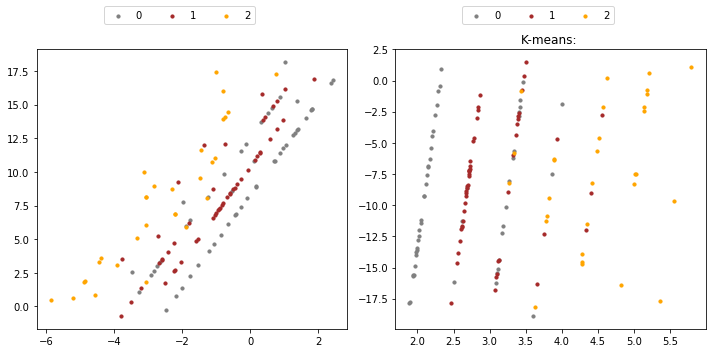

In [106]:
draw_projection(proj_set, data, label, proj_labels,fname)

In [19]:
get_weighted_GONG(data, label, proj_set, proj_labels)#我们的方法

{0: 0.9937931034482759, 1: 0.6833333333333333, 2: 0.4444444444444444, 3: 0.5245098039215685, 4: 0.9722222222222222}
{0: 0.993103448275862, 1: 0.6916666666666667, 2: 0.4583333333333333, 3: 0.4313725490196078, 4: 0.9722222222222222}
-------
{0: 0.9937931034482759, 1: 0.6916666666666667, 2: 0.4583333333333333, 3: 0.5245098039215685, 4: 0.9722222222222222}
{0: 145, 1: 20, 2: 6, 3: 17, 4: 12}


0.9063333333333332

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [102]:
def test_lda(data, label,fname):
    clf = LDA(n_components=2)
    new_data_LDA = clf.fit_transform(data, label)
    plt.scatter(new_data_LDA[:, 0], new_data_LDA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_LDA, label, 'test')
    plt.title('LDA: ' + str(round(GONG, 4)))
    
    plt.savefig('./result_fig/' + fname + '/' + fname.split('.')[0] + '_LDA.png')
    plt.show()
    
    return GONG

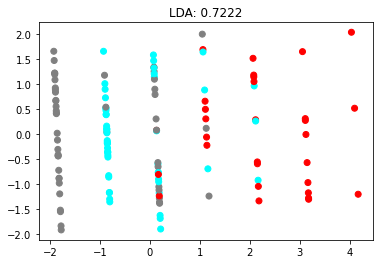

0.7222222222222222

In [103]:
test_lda(data, label,fname)  

In [84]:
def test_pca(data, label,fname):
    pca = PCA(n_components=2)
    new_data_PCA = pca.fit_transform(data)

    plt.scatter(new_data_PCA[:, 0], new_data_PCA[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_PCA, label, 'test')
    plt.title('PCA: ' + str(round(GONG, 4)))
    
    plt.savefig('./result_fig/' + fname + '/' + fname.split('.')[0] + '_PCA.png')

    plt.show()
    return GONG

In [85]:
def test_tsne(data, label,fname):
    sc = StandardScaler()
    data_std = sc.fit_transform(data)

    tsne = TSNE(n_components=2, learning_rate=100)
    new_data_tsne = tsne.fit_transform(data)

    plt.scatter(new_data_tsne[:, 0], new_data_tsne[:, 1], c=label,
            cmap=matplotlib.colors.ListedColormap(colors))

    GONG = get_GONG_value(new_data_tsne, label, 'test')
    plt.title('t-SNE: ' + str(round(GONG, 4)))
    
    plt.savefig('./result_fig/' + fname + '/' + fname.split('.')[0] + '_TSNE.png')

    plt.show()
    return GONG

In [25]:
"""
Scikit-learn-compatible Kernel Discriminant Analysis.

Used in
David Diaz-Vico, Jose R. Dorronsoro
"Deep vs Kernel Fisher Discriminant Analysis"

Based on algorithm 5 in
Zhihua Zhang, Guang Dai, Congfu Xu, Michael I. Jordan
"Regularized Discriminant Analysis, Ridge Regression and Beyond"
http://www.jmlr.org/papers/v11/zhang10b.html

,author: David Diaz Vico
,license: MIT
"""

import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics.pairwise import (chi2_kernel, laplacian_kernel,
                                      linear_kernel, polynomial_kernel,
                                      rbf_kernel, sigmoid_kernel)
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.datasets import make_classification
from scipy.sparse import csc_matrix, csr_matrix

class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin,
                                 TransformerMixin):
    """Kernel Discriminant Analysis.

    Parameters
    ----------
    lmb: float (>= 0.0), default=0.001
         Regularization parameter
    kernel: {"chi2", "laplacian", "linear", "polynomial", "rbf", "sigmoid"},
            default='rbf'
            Kernel.
    degree: integer, default=3
    gamma: float, default=None
    coef0: integer, default=1

    """

    def __init__(self, lmb=0.001, kernel='rbf', degree=3, gamma=None, coef0=1):
        self.lmb = lmb
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0

    def _kernel(self, X, Y=None):
        """Kernel"""
        kernel = None
        if self.kernel == 'chi2':
            kernel = chi2_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'laplacian':
            kernel = laplacian_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'linear':
            kernel = linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            kernel = polynomial_kernel(X, Y, degree=self.degree,
                                       gamma=self.gamma, coef0=self.coef0)
        elif self.kernel == 'rbf':
            kernel = rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'sigmoid':
            kernel = sigmoid_kernel(X, Y, gamma=self.gamma, coef0=self.coef0)
        return kernel

    def fit(self, X, y):
        """Fit KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           Training set.
        y: numpy array of shape [n_samples]
           label values. Only works for 2 classes.

        Returns
        -------
        self

        """
        n = len(X)
        self._X = X
        self._H = np.identity(n) - np.matmul(1. / n * np.ones(n), np.ones(n).T) #np.ones(n) , np.ones(n).T
        self._E = OneHotEncoder().fit_transform(y.reshape(n, 1))
        _, counts = np.unique(y, return_counts=True)
        K = self._kernel(X)
        C = np.matmul(np.matmul(self._H, K), self._H)
        self._Delta = np.linalg.inv(C + self.lmb * np.identity(n))
        A = np.matmul(csc_matrix.toarray(self._E.T), C)
        B = np.matmul(self._Delta , csr_matrix.toarray(self._E))
        self._Pi_12 = np.diag(np.sqrt(1.0 / counts))
        P = np.matmul(self._Pi_12 , A)
        Q = np.matmul(B , self._Pi_12)
        R = np.matmul(P, Q)
        V, self._Gamma, self._U = np.linalg.svd(R, full_matrices=False)
        return self

    def transform(self, X):
        """Transform data with the trained KFDA model.

        Parameters
        ----------
        X: numpy array of shape [n_samples, n_features]
           The input data.

        Returns
        -------
        y_pred: array-like, shape (n_samples, labels_shape)
                Transformations for X.

        """
        _K = self._kernel(X, self._X)
        K = _K - np.mean(_K, axis=0)
        C = np.matmul(self._H, K.T)
        x = np.matmul(np.matmul(self._U, self._Pi_12), csc_matrix.toarray(self._E.T))
        T = np.matmul(x,self._Delta)
        Z = np.matmul(T, C)
        return Z.T

In [86]:
def test_kda(data, label,fname):
    kda = KernelDiscriminantAnalysis()
    a = kda.fit(data, label)
    b = kda.transform(data)
    new_data_KDA = kda.fit_transform(data,label)
    plt.scatter(new_data_KDA[:,0],new_data_KDA[:,1],c=label,cmap = matplotlib.colors.ListedColormap(colors))
    GONG = get_GONG_value(new_data_KDA, label, 'test')
    plt.title('KDA: ' + str(round(GONG, 4)))
    plt.show()
    
    plt.savefig('./result_fig/' + fname + '/' + fname.split('.')[0] + '_KDA.png')
    return GONG

In [80]:
#2个类的文件都要踢出来
import os

path = r'.\Data'
dirs = os.listdir(path)
file_names = []
for fname in dirs:
    data, label = read_data_from_file(fname)
    file_names.append(fname)
    # if(len(set(label)) == 2):
    print(fname, len(set(label)))

# file_names

balance-scale.csv 3
bbdm13_origClassLabels.csv 5
cereal_origClassLabels.csv 7
dermatology.csv 6
ecoliproteins.csv 8
hayes-roth.csv 3
interleaved_100_500_3_25_cramped_rotated.csv 3
interleaved_250_500_3_0_notCramped_rotated.csv 3
iris.csv 3
italianwines.csv 13
JavierGeneratedData_3dinterleaved_3classes_origClassLabels.csv 3
JavierGeneratedData_3dinterleaved_4classes_origClassLabels.csv 4
JavierGeneratedData_3dinterleaved_5classes_origClassLabels.csv 5
lenses.csv 3
ms_interleaved_120_240_3d_25_centeredClusters.csv 3
ms_interleaved_120_240_3d_50_centeredClusters.csv 3
ms_interleaved_40_80_3d_0.csv 3
ms_interleaved_40_80_3d_50.csv 3
ms_interleaved_60_120_3d_0_centeredClusters.csv 3
ms_interleaved_60_120_3d_25_centeredClusters.csv 3
ms_interleaved_60_120_3d_50_centeredClusters.csv 3
musicnetgroups.csv 6
n100-d10-c3-spr0.1-out0.csv 3
n100-d10-c3-spr0.2-out0.csv 3
n100-d10-c5-spr0.1-out0.csv 5
n100-d10-c5-spr0.2-out0.csv 5
n100-d5-c3-spr0.1-out0.csv 3
n100-d5-c3-spr0.2-out0.csv 3
n100-d5-c5-s

In [ ]:
#生成一个list,包含所有数据集的

all_GONG_list = []

for fname in file_names[7:12]:
    print("**************************current_file**************************",fname)
    
#     path="./result_fig/" + fname
#     isExists=os.path.exists(path)
#     if not isExists:
#         os.makedirs(path) 
    data, label = read_data_from_file(fname)
    # data, label = X, y
    label = get_label_right(label)
    label = np.array(list(map(int, label)))
    vec_dict, vecs = get_between_class_opt_vec(data, label)
    id_pair, id_vecs = get_id_pair(vec_dict)
    planes, pid_labels, pid_vids = get_all_plains(vecs, id_pair)
    k_means = K_means(planes,k = 2)
    k_means_labels = k_means.fit()
    clusters = k_means.get_clusters()
    proj_labels, proj_set = get_proj_set_and_label(clusters, id_vecs, pid_labels, pid_vids)
    draw_projection(proj_set, data, label, proj_labels,fname)
    
    GONG_list = []
    GONG_list.append(fname)
    GONG_list.append(get_weighted_GONG(data, label, proj_set, proj_labels))
    GONG_list.append(test_lda(data, label,fname))
    GONG_list.append(test_pca(data, label,fname))
#     GONG_list.append(test_tsne(data, label))
    GONG_list.append(test_kda(data, label,fname))
#     print(GONG_list)
    data_write_csv("save_result.csv",GONG_list)
    all_GONG_list.append(GONG_list)
    


**************************current_file************************** interleaved_250_500_3_0_notCramped_rotated.csv
dists--> 2.815599980617789e-16
[[ 0.36459892 -0.44845171  0.81606293]
 [-0.93100958 -0.15956844  0.32826677]]
dists--> 1.8958112227689728e-16
[[ 0.36459892 -0.44845171  0.81606293]
 [ 0.44248524  0.8545583   0.27191345]]
dists--> 4.85722573273506e-17
[[ 0.99885401  0.00635728 -0.04743691]
 [ 0.00421939 -0.99897659 -0.04503291]]
vids:  [0, 1, 2]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.8513224401182298
            Iterations: 30
            Function evaluations: 265
            Gradient evaluations: 30
[-0.17244116 -0.46605538  0.86779086  0.98487856 -0.09677216  0.14373224]
1.0000022771866692 1.0000047941863495
dists--> 0.851318432303392
vids:  [0, 1]
dists--> 2.815599980617789e-16
row_num 1
[0, 1, 2]
[0, 1, 2]
{0: 0.9541666666666667, 1: 0.8226991492652745, 2: 0.7604467194043741}
{0: 0.9541666666666667, 1: 0.8226991492652745,

In [70]:
import csv
import codecs

def data_write_csv(file_name, data):#file_name为写入CSV文件的路径，datas为要写入数据列表
    file_csv = codecs.open(file_name,'a+','utf-8')#追加
    writer = csv.writer(file_csv, delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
#     for data in datas:
    writer.writerow(data)
    print("保存文件成功，处理结束")

In [69]:
a = ["a123aa",1,2123,3]
data_write_csv("save_result.csv",a)

保存文件成功，处理结束
